In [1]:
import glob
import os
import random
from datetime import datetime

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rasterio.features
import rasterio.warp
from shapely.geometry import box
from torchgeo.datasets import CopernicusBenchLC100ClsS3
from tqdm import tqdm

root = "../data"
dataset = CopernicusBenchLC100ClsS3(root=root, split="train", download=True, checksum=True)

100%|██████████| 1.71G/1.71G [00:21<00:00, 79.7MB/s]


In [33]:
dataset.files

,PID,unknown,shrubs,herbaceous vegetation,cultivated and managed vegetation/agriculture,urban / built-up,bare / sparse vegetation,snow and ice,permanent water bodies,herbaceous wetland,...,closed forest (deciduous broad leaf),closed forest (mixed),closed forest (other),open forest (evergreen needle leaf),open forest (evergreen broad leaf),open forest (deciduous needle leaf),open forest (deciduous broad leaf),open forest (mixed),open forest (other),oceans / seas
0,0200599_-70.25_-55.25,0,0,1,0,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,1
1,0203488_-68.00_-54.75,0,1,1,0,1,1,1,1,1,...,1,0,1,0,0,0,1,0,1,1
2,0207805_-68.75_-54.00,0,1,1,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
3,0209248_-68.00_-53.75,0,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,0216431_-72.25_-52.50,0,1,1,0,0,1,1,1,1,...,1,0,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,0934384_136.00_72.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5177,0937109_97.25_72.50,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5178,0938387_56.75_72.75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5179,0939240_-90.00_73.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


torch.Size([21, 94, 94])


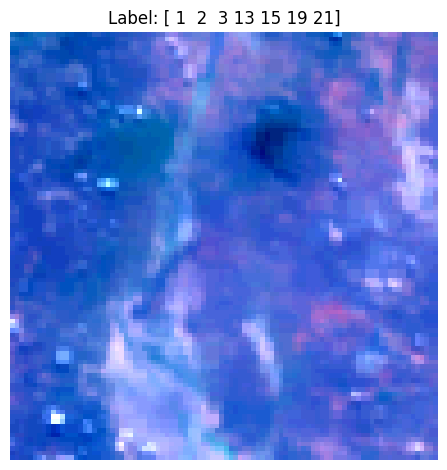

In [ ]:
idx = random.randint(0, len(dataset) - 1)
sample = dataset[idx]
fig = dataset.plot(sample)
print(sample["image"].shape)

In [36]:
dataset.split

'train'

In [53]:
data = {}
geoms = []
for split in ("train", "val", "test"):
    dataset = CopernicusBenchLC100ClsS3(root=root, split=split)
    split_images = []
    for idx in tqdm(range(len(dataset))):
        row = dataset.files.iloc[idx].values
        pid = row[0]
        paths = sorted(
            glob.glob(os.path.join(dataset.root, dataset.directory, "s3_olci", pid, "*.tif"))
        )
        for path in paths:
            folder = path.split(os.sep)[-2]
            filename = os.path.basename(path)
            data[os.path.join(folder, filename)] = {
                "path": path,
                "filename": filename,
                "folder": folder,
                "label": row[1:].astype(np.int64),
                "split": split,
                "date": datetime.strptime(os.path.basename(path).split("_")[1], "%Y%m%dT%H%M%S"),
            }
            with rasterio.open(path) as f:
                geoms.append(box(*rasterio.warp.transform_bounds(f.crs, "EPSG:4326", *f.bounds)))

df = gpd.GeoDataFrame(pd.DataFrame(data).T, geometry=geoms, crs="EPSG:4326")
df.to_parquet("../data/lc100_s3.parquet")

100%|██████████| 1727/1727 [00:00<00:00, 2166.10it/s]


In [54]:
df = gpd.read_parquet("../data/lc100_s3.parquet")
df.head()

,path,filename,folder,label,split,date,geometry
0200599_-70.25_-55.25/S3A_20190507T135736_20190507T135744.tif,../data/lc100_s3/s3_olci/0200599_-70.25_-55.25...,S3A_20190507T135736_20190507T135744.tif,0200599_-70.25_-55.25,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",train,2019-05-07 13:57:36,"POLYGON ((-70.12249 -55.37575, -70.12249 -55.1..."
0200599_-70.25_-55.25/S3B_20190810T135525_20190810T135539.tif,../data/lc100_s3/s3_olci/0200599_-70.25_-55.25...,S3B_20190810T135525_20190810T135539.tif,0200599_-70.25_-55.25,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",train,2019-08-10 13:55:25,"POLYGON ((-70.12249 -55.37575, -70.12249 -55.1..."
0203488_-68.00_-54.75/S3A_20190504T133509_20190504T133531.tif,../data/lc100_s3/s3_olci/0203488_-68.00_-54.75...,S3A_20190504T133509_20190504T133531.tif,0203488_-68.00_-54.75,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, ...",train,2019-05-04 13:35:09,"POLYGON ((-67.87491 -54.87718, -67.87491 -54.6..."
0203488_-68.00_-54.75/S3B_20190811T132914_20190811T132933.tif,../data/lc100_s3/s3_olci/0203488_-68.00_-54.75...,S3B_20190811T132914_20190811T132933.tif,0203488_-68.00_-54.75,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, ...",train,2019-08-11 13:29:14,"POLYGON ((-67.87491 -54.87718, -67.87491 -54.6..."
0207805_-68.75_-54.00/S3A_20190813T131623_20190813T131654.tif,../data/lc100_s3/s3_olci/0207805_-68.75_-54.00...,S3A_20190813T131623_20190813T131654.tif,0207805_-68.75_-54.00,"[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",train,2019-08-13 13:16:23,"POLYGON ((-68.6241 -54.12529, -68.6241 -53.874..."
